# results

In [ ]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

cuda


In [3]:
    # Define input and mask folders for the JNU_FMI dataset
    test_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\test'
    test_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\test'
    
    support_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\train'
    support_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\train'
    

In [4]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None, figsize=(15, 15)):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().astype(np.float32).squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [5]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [6]:
#Accuracy score implemented
def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    correct = (y_pred == y_true).sum().item()
    total = y_true.numel()
    accuracy = correct / total
    
    return accuracy

In [7]:
def sensitivity_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum().item()
    sensitivity = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    return sensitivity

In [8]:
def precision_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_positives = ((y_pred == 1) & (y_true == 0)).sum().item()
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0

    return precision

In [9]:
def jaccard_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    intersection = ((y_pred == 1) & (y_true == 1)).sum().item()
    union = ((y_pred == 1) | (y_true == 1)).sum().item()
    jaccard = intersection / union if union != 0 else 0

    return jaccard

In [10]:
 

def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with hot encoded selection of areas."""
    # Load input image
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    img = np.array(img)
    img = img.astype(np.float32)
    return img
#     

# def process_segmentation(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
#     """Process segmentation mask."""
#     seg = PIL.Image.open(path)
#     seg = seg.resize(size, resample=PIL.Image.NEAREST)
#     seg = np.array(seg)
#     seg = np.expand_dims(seg == 255, axis=0)
#     return seg.astype(np.float32)

def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    # seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
    # seg = seg_mask.astype(np.float32)
    #seg = np.expand_dims(seg == 255, axis=0)
    seg = np.expand_dims(seg > 0, axis=0)
    return seg.astype(np.float32)

    #return seg

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    # Apply the mask to the input image
    img_with_rois = np.where(seg_mask[0], image, 0)
    img_with_rois = img_with_rois.astype(np.float32)



    return img_with_rois


def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    # Sort images based on numerical values in filenames
    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        
    count = 1
    for file in input_files:
        img = process_image(file,mask_path, size=size)
        img_name = file.stem

        # Load segmentation mask
        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        # Apply regions of interest (ROIs) to input image
        #img_with_co = apply_rois(img, seg)

        data.append((img / 255.0, seg))
        count+=1

    return data



@dataclass
class JNU_FMI:
    input_folder: str
    label: str
    size: Tuple[int, int] = (128, 128)
    label_name: Optional[Literal["head", "symp", "background"]] = None
    
    def __post_init__(self):
        self._data = load_dataset(self.input_folder, self.label, size=self.size)
        T = torch.from_numpy
        
        # Assign indices based on sorted filenames
        self._data = [(T(x)[None], T(y)) for x, y in self._data]
         
        
        if self.label is not None:
            self.masks = sorted(os.listdir(self.label), key=lambda x: int(x.split('_')[-2]))
            if self.label in self.masks:
                self._ilabel = {"head": 1, "symp": 2, "background": 0}[self.label]
        
        self.idxs = list(range(len(self._data)))
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        img, seg = self._data[self.idxs[idx]]
        # if self.label is not None:
        #     seg = seg[self.label_name][None]
        return img, seg

In [11]:
@torch.no_grad()
def inferencesupport(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    dicescore = dice_score(hard_pred, label)
    accuracy = accuracy_score(hard_pred,label)
    sensitivity =sensitivity_score(hard_pred,label)
    precision=precision_score(hard_pred,label)
    jaccard=jaccard_score(hard_pred,label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': dicescore,
            'accuracy' : accuracy,
            'sensitivity':sensitivity,
            'precision':precision,
            'jaccard' : jaccard}

In [12]:


#support_images, support_labels = zip(*itertools.islice(d_support, n_support))
#support_images = torch.stack(support_images).to(device)
#support_labels = torch.stack(support_labels).to(device)
import random
n_support = 64

d_support = JNU_FMI(support_input_folder, label=support_mask_folder)
d_test = JNU_FMI(test_input_folder, label=test_mask_folder)

# Create a list of indices
#indices = list(range(len(d_support)))

# Shuffle the indices
#random.shuffle(indices)

# Select n_support random indices
#random_indices = indices[:n_support]

# Use the selected random indices to extract corresponding elements from d_support
#random_support = [d_support[i] for i in random_indices]

# Unzip the random_support into images and labels
#support_images, support_labels = zip(*random_support)

# Convert support_images into a PyTorch tensor and move it to the device
#support_images = torch.stack(support_images).to(device)

In [13]:
import pandas as pd
import random

support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

# Create empty DataFrames for each metric
df_dicescore = pd.DataFrame(columns=support_set_sizes)
df_accuracy = pd.DataFrame(columns=support_set_sizes)
df_sensitivity = pd.DataFrame(columns=support_set_sizes)
df_precision = pd.DataFrame(columns=support_set_sizes)
df_jaccard = pd.DataFrame(columns=support_set_sizes)

for image, label in d_test:
    dice_scores = {}
    acc = {}
    sens = {}
    prec = {}
    jac = {}
    for N in support_set_sizes:
        # Randomly select N indices for both images and labels
        random_indices = random.sample(range(len(d_support)), N)
        random_support = [(d_support[i][0], d_support[i][1]) for i in random_indices]
        
        # Unzip the random_support into images and labels
        support_images, support_labels = zip(*random_support)
        
        # Convert support_images into a PyTorch tensor and move it to the device
        support_images = torch.stack(support_images).to(device)
        support_labels = torch.stack(support_labels).to(device)
        
        # Call the function for inference
        vals = inferencesupport(model, image, label, support_images, support_labels)
        
        # Store the metrics
        dice_scores[N] = vals['score'] if 'score' in vals else None
        acc[N] = vals['accuracy'] if 'accuracy' in vals else None
        sens[N] = vals['sensitivity'] if 'sensitivity' in vals else None
        prec[N] = vals['precision'] if 'precision' in vals else None
        jac[N] = vals['jaccard'] if 'jaccard' in vals else None

    df_dicescore = pd.concat([df_dicescore, pd.DataFrame(dice_scores, index=[0])], ignore_index=True)
    df_accuracy = pd.concat([df_accuracy, pd.DataFrame(acc, index=[0])], ignore_index=True)
    df_sensitivity = pd.concat([df_sensitivity, pd.DataFrame(sens, index=[0])], ignore_index=True)
    df_precision = pd.concat([df_precision, pd.DataFrame(prec, index=[0])], ignore_index=True)
    df_jaccard = pd.concat([df_jaccard, pd.DataFrame(jac, index=[0])], ignore_index=True)

C:\Users\cinth\AppData\Local\Temp\ipykernel_13456\1862357065.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dicescore = pd.concat([df_dicescore, pd.DataFrame(dice_scores, index=[0])], ignore_index=True)
C:\Users\cinth\AppData\Local\Temp\ipykernel_13456\1862357065.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_accuracy = pd.concat([df_accuracy, pd.DataFrame(acc, index=[0])], ignore_index=True)
C:\Users\cinth\AppData\Local\Temp\ipykernel_13456\1862357065.py:43: FutureWarning: The

In [14]:
df_dicescore.to_csv('random_dicescore_with.csv', index=False)
df_accuracy.to_csv('random_accuracy_with.csv', index=False)
df_sensitivity.to_csv('random_sensitivity_with.csv', index=False)
df_precision.to_csv('random_precision_with.csv', index=False)
df_jaccard.to_csv('random_jaccard_with.csv', index=False)

In [15]:
meandice_df = pd.DataFrame(df_dicescore.mean().to_dict(),index=['DiceScore'])
meanacc_df = pd.DataFrame(df_accuracy.mean().to_dict(),index=['Accuracy'])
meansens_df=pd.DataFrame(df_sensitivity.mean().to_dict(),index=['Sensitivity'])
meanprec_df= pd.DataFrame(df_precision.mean().to_dict(),index=['Precision'])
meanjac_df = pd.DataFrame(df_jaccard.mean().to_dict(),index=['Jaccard'])

In [16]:
df=[meandice_df,meanacc_df,meansens_df,meanprec_df,meanjac_df]
result=pd.concat(df)
result

,1,2,4,8,16,32,64
DiceScore,0.284945,0.374974,0.475064,0.578702,0.649489,0.696892,0.733364
Accuracy,0.868216,0.881466,0.894989,0.907313,0.920598,0.933103,0.940727
Sensitivity,0.254231,0.369984,0.478525,0.601764,0.684324,0.734833,0.776590
Precision,0.396083,0.490705,0.557864,0.616115,0.661829,0.694456,0.718008
Jaccard,0.183795,0.270876,0.362477,0.459840,0.536762,0.594868,0.639571


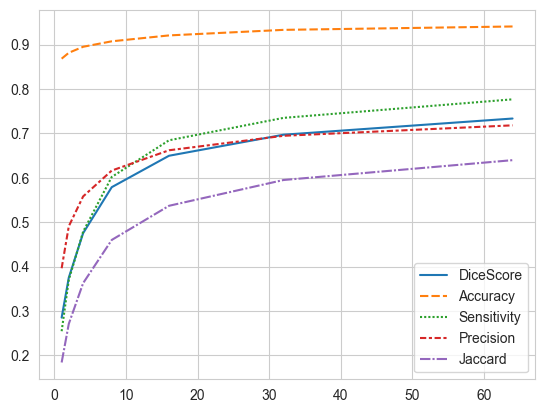

In [17]:
import seaborn as sns
sns.lineplot(result.transpose())
plt.show()

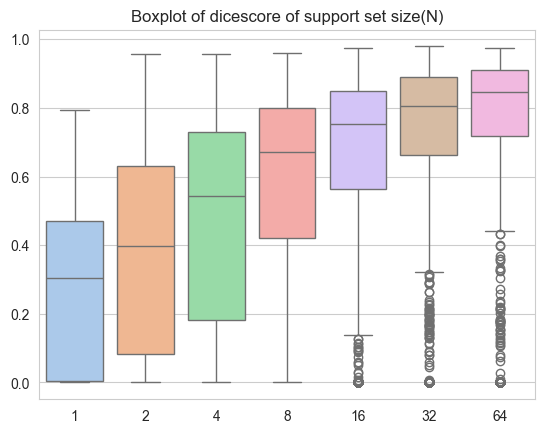

In [18]:
import seaborn as sns
#df_dicescore.plot(kind='box')
ax = sns.boxplot(data=df_dicescore, palette='pastel')
plt.title('Boxplot of dicescore of support set size(N)')
plt.show()

### Ensemble with random support set

In [19]:
d_support = JNU_FMI(support_input_folder, label=support_mask_folder)
d_test = JNU_FMI(test_input_folder, label=test_mask_folder)


support_sizes = [4,8,16,32,64]  # Adjust according to your requirements
n_ensemble_values = [3, 5, 8, 10]  # Adjust according to your requirements
# 
# # Initialize a dictionary to store average Dice scores
# average_dice_scores = {}
# 
# # Iterate over different support sizes
# for support_size in support_sizes:
#     random_indices = random.sample(range(len(d_support)), N)
#     random_support = [(d_support[i][0], d_support[i][1]) for i in random_indices]
# 
#     # Unzip the random_support into images and labels
#     support_images, support_labels = zip(*random_support)
# 
#     # Convert support_images into a PyTorch tensor and move it to the device
#     support_images = torch.stack(support_images).to(device)
#     support_labels = torch.stack(support_labels).to(device)
#     # Iterate over different ensemble sizes
#     for n_ensemble in n_ensemble_values:
# 
#         # get various support sets
#         seeds = range(n_ensemble)
#         supports = {
#             seed: sample_support(seed)
#             for seed in range(n_ensemble)
#         }
# 
#         all_scores = []
# 
#         # go through the number of experiments
#         for image, label in d_test:
# 
#             # Initialize a list to store scores for each ensemble
#             ensemble_scores = []
# 
#             # go through the number of predictions we will ensemble
#             for j in range(n_ensemble):
#                 # get support set
#                 #support_images, support_labels = sample_support(j)
# 
#                 # perform inference
#                 vals = inference(model, image, label, support_images[:support_size], support_labels[:support_size])
#                 dice_score_value = vals['score'] if 'score' in vals else None
#                 ensemble_scores.append(dice_score_value)
# 
#             # Calculate the average score for this image across all ensembles
#             average_score = sum(ensemble_scores) / n_ensemble
# 
#             # Append the score of this prediction to the list
#             all_scores.append(average_score)
# 
#         # Calculate the average score across all predictions
#         average_dice_score = sum(all_scores) / len(all_scores)
# 
#         # Store the average Dice score in the dictionary
#         average_dice_scores[(support_size, n_ensemble)] = average_dice_score
# 
# # Print and/or save the dictionary as needed
# print("Average Dice Scores:")
# for key, value in average_dice_scores.items():
#     print(f"Support Size: {key[0]}, Ensemble Size: {key[1]}, Average Dice Score: {value:.4f}")

In [ ]:
import random

# Initialize a dictionary to store average Dice scores
average_dice_scores = {}

# Iterate over different support sizes
for support_size in support_sizes:
    random_indices = random.sample(range(len(d_support)), support_size)
    random_support = [(d_support[i][0], d_support[i][1]) for i in random_indices]
        
    # Unzip the random_support into images and labels
    support_images, support_labels = zip(*random_support)
        
    # Convert support_images into a PyTorch tensor and move it to the device
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    
    # Iterate over different ensemble sizes
    for n_ensemble in n_ensemble_values:

        all_scores = []

        # go through the number of experiments
        for image, label in d_test:

            # Initialize a list to store scores for each ensemble
            ensemble_scores = []

            # go through the number of predictions we will ensemble
            for j in range(n_ensemble):
                # perform inference
                vals = inferencesupport(model, image, label, support_images[:support_size], support_labels[:support_size])
                dice_score_value = vals['score'] if 'score' in vals else None
                ensemble_scores.append(dice_score_value)

            # Calculate the average score for this image across all ensembles
            average_score = sum(ensemble_scores) / n_ensemble

            # Append the score of this prediction to the list
            all_scores.append(average_score)

        # Calculate the average score across all predictions
        average_dice_score = sum(all_scores) / len(all_scores)

        # Store the average Dice score in the dictionary
        average_dice_scores[(support_size, n_ensemble)] = average_dice_score

# Print and/or save the dictionary as needed
print("Average Dice Scores:")
for key, value in average_dice_scores.items():
    print(f"Support Size: {key[0]}, Ensemble Size: {key[1]}, Average Dice Score: {value:.4f}")
